In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression library
from sklearn.linear_model import LogisticRegression

# Libraries to scale the data
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.decomposition import PCA

# Bayesian Optimization libraries
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection

from sklearn import ensemble

# Performance Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Ignores runtime warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline

### Analysis on K-means Imputed and Outlier handled dataset

In [2]:
df1 = pd.read_csv("../processed-datasets/data_outliers_handled_kmeans_imputed.csv")

In [3]:
df1.head()

,Unnamed: 0,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
0,0,222.0,0.0,7.88,0.050,10.500,0.050,4.25000,11.60000,1.99000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2737.00000,12390.0,305.0,134.0
1,1,222.0,0.0,10.90,1.555,61.505,0.725,7.74125,12.56125,2.64375,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12591.0,503.0,272.0
2,2,222.0,0.0,6.00,0.020,25.100,0.300,4.41000,12.56125,2.30000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12724.0,639.0,414.0
3,3,222.0,0.0,9.06,0.280,12.000,0.070,1.88000,5.08000,1.01000,...,194.00000,83.0000,356.00000,89.5000,762.000,144.00000,1832.00000,12894.0,308.0,127.0
4,4,222.0,0.0,4.93,0.070,16.500,0.150,2.32000,8.23000,1.52000,...,257.00000,106.1375,437.54375,97.8675,936.000,171.00000,2355.00000,12535.0,348.0,155.0


In [4]:
df1.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df1.sample(5)

,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,Gd,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
140,235.0000,0.0,7.92,0.010,22.86,0.070,1.71000,3.42000,0.54,19.01,...,77.77,28.14,131.49,26.61,280.39,48.08,931.32,11428.77,328.92,188.60
1381,107.0000,0.0,2.70,0.710,17.20,0.300,2.42000,2.99000,0.13,18.90,...,91.90,35.80,162.00,36.00,336.00,59.00,1127.00,9180.00,364.00,307.00
770,839.3875,0.0,16.33,1.555,30.28,0.725,7.74125,12.56125,0.51,42.87,...,139.74,48.21,214.42,41.05,351.32,62.10,771.96,11169.09,77.46,30.33
592,253.0000,0.0,16.20,0.020,3.44,0.110,2.73000,5.56000,0.51,18.90,...,42.50,11.50,41.20,6.86,62.20,9.56,368.00,10728.00,217.00,109.00
852,839.3875,0.0,19.84,0.230,4.45,0.070,1.63000,3.12000,0.22,16.18,...,63.47,23.26,107.13,21.67,191.23,35.33,670.50,10951.25,228.86,111.01


In [6]:
X = df1.drop('Feature', axis=1).values
y = df1.Feature.values

### Splitting the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Scaling the data using Standard Scaler

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.shape

(2390, 20)

### Fitting the base model

In [10]:
rf_base = ensemble.RandomForestClassifier()

rf_base.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [11]:
y_pred = rf_base.predict(X_test_scaled)

In [12]:
print("Accuracy of test set on base model: ", round(accuracy_score(y_test, y_pred), 2))

Accuracy of test set on base model:  0.96


In [13]:
print("Classification report of test set: \n\n", classification_report(y_test, y_pred))

Classification report of test set: 

               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       334
         1.0       0.97      0.95      0.96       264

    accuracy                           0.96       598
   macro avg       0.96      0.96      0.96       598
weighted avg       0.96      0.96      0.96       598



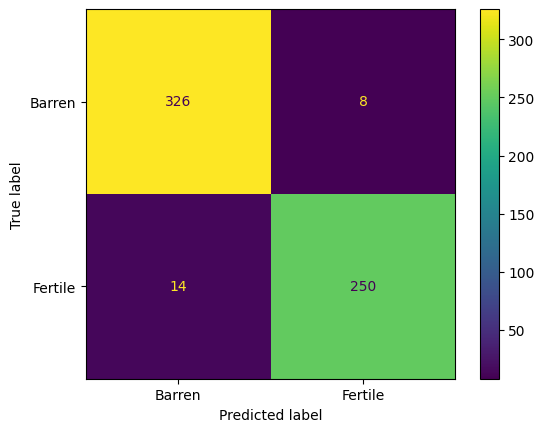

In [14]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Hyper-Parameter Tuning

### Grid Search Optimization with stratified K-fold Cross Validation

In [15]:
Stratified_kf = StratifiedKFold(n_splits=10, shuffle=True)

In [16]:
param_grid = {
    
    'max_depth': np.arange(3, 15, 2),
    'n_estimators': np.arange(100, 500, 100),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
    
}

In [17]:
clf = GridSearchCV(estimator = ensemble.RandomForestClassifier(), param_grid=param_grid, scoring='accuracy',
                   cv = Stratified_kf, n_jobs=-1, verbose=10, return_train_score=True)

In [18]:
clf.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 2/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 2/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.871, test=0.900) total time=   0.4s
[CV 9/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 9/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.877, test=0.837) total time=   0.4s
[CV 7/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 7/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.877, test=0.866) total time=   0.9s
[CV 6/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 6/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.877, test=0.849) total time=   1.3s
[CV 4/10; 4/96] START criterion=gini,

[CV 3/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 3/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.876, test=0.904) total time=   0.4s
[CV 1/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 1/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.880, test=0.879) total time=   0.9s
[CV 9/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 9/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.881, test=0.837) total time=   0.9s
[CV 7/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 7/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.874, test=0.854) total time=   1.3s
[CV 5/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 5/10; 4/9

[CV 7/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 7/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.885, test=0.874) total time=   0.4s
[CV 6/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 6/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.874, test=0.845) total time=   0.9s
[CV 4/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 4/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.883, test=0.870) total time=   1.3s
[CV 2/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 2/10; 4/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400;, score=(train=0.874, test=0.900) total time=   1.7s
[CV 10/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 10/10; 4

[CV 8/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 8/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.874, test=0.849) total time=   0.4s
[CV 5/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 5/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.882, test=0.837) total time=   0.8s
[CV 2/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 2/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.877, test=0.904) total time=   1.3s
[CV 10/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 10/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.882, test=0.870) total time=   1.2s
[CV 8/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 8/10; 4

[CV 1/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 1/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.891, test=0.883) total time=   0.4s
[CV 10/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 10/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.881, test=0.862) total time=   0.4s
[CV 8/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 8/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.876, test=0.854) total time=   0.8s
[CV 5/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 5/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.880, test=0.824) total time=   1.2s
[CV 3/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 3/10; 4

[CV 4/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 4/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.879, test=0.874) total time=   0.4s
[CV 4/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 4/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.880, test=0.870) total time=   0.9s
[CV 3/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 3/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.886, test=0.904) total time=   1.3s
[CV 1/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 1/10; 4/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400;, score=(train=0.883, test=0.883) total time=   1.6s
[CV 9/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 9/10; 4/9

[CV 6/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 6/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.871, test=0.849) total time=   0.4s
[CV 3/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 3/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.880, test=0.908) total time=   0.9s
[CV 1/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 1/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.878, test=0.874) total time=   1.2s
[CV 9/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 9/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.878, test=0.833) total time=   1.3s
[CV 7/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 7/10; 4/9

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  5,  7,  9, 11, 13]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': array([100, 200, 300, 400])},
             return_train_score=True, scoring='accuracy', verbose=10)

In [19]:
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=13, max_features='log2',
                       n_estimators=300)

In [20]:
clf.best_score_

0.9644351464435147

In [21]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 13,
 'max_features': 'log2',
 'n_estimators': 300}

In [22]:
print("Best accuracy obtained: ", round(clf.best_score_, 2))

Best accuracy obtained:  0.96


In [24]:
y_pred_1 = clf.predict(X_test_scaled)

In [25]:
print("Accuracy of test data - GridSearch CV: ", round(accuracy_score(y_test, y_pred_1), 2))

Accuracy of test data - GridSearch CV:  0.96


In [26]:
print("Classification report for test data - Gridsearch CV: \n\n", classification_report(y_test, y_pred_1))

Classification report for test data - Gridsearch CV: 

               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       334
         1.0       0.97      0.94      0.95       264

    accuracy                           0.96       598
   macro avg       0.96      0.96      0.96       598
weighted avg       0.96      0.96      0.96       598



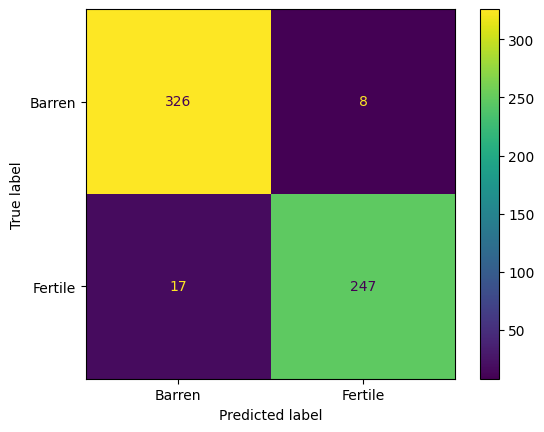

In [27]:
cm = confusion_matrix(y_test, y_pred_1)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Plotting the learning curves

In [28]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [29]:
clf.cv_results_['mean_test_score']

array([0.8665272 , 0.8665272 , 0.86359833, 0.8665272 , 0.86569038,
       0.8665272 , 0.86569038, 0.86443515, 0.9251046 , 0.9209205 ,
       0.92175732, 0.92384937, 0.92008368, 0.92050209, 0.92384937,
       0.92175732, 0.94100418, 0.94728033, 0.94769874, 0.94476987,
       0.94309623, 0.94560669, 0.94644351, 0.94644351, 0.9539749 ,
       0.95732218, 0.95606695, 0.95481172, 0.95271967, 0.95648536,
       0.95899582, 0.95648536, 0.95983264, 0.958159  , 0.95941423,
       0.95774059, 0.95606695, 0.95899582, 0.95941423, 0.95899582,
       0.95606695, 0.96150628, 0.95774059, 0.95941423, 0.958159  ,
       0.96317992, 0.96066946, 0.95983264, 0.8665272 , 0.86527197,
       0.86610879, 0.86903766, 0.86317992, 0.86610879, 0.8665272 ,
       0.86569038, 0.92175732, 0.92594142, 0.92803347, 0.9292887 ,
       0.92259414, 0.92343096, 0.92468619, 0.9251046 , 0.94686192,
       0.94686192, 0.95146444, 0.9460251 , 0.94435146, 0.94728033,
       0.94811715, 0.94686192, 0.958159  , 0.95774059, 0.95732

### Hyper-Parameter Tuning using Bayesian Optimization

In [30]:
def optimize(params, param_names, x, y):
    params = dict(zip(param_names, params))
    model = ensemble.RandomForestClassifier(**params)
    kfold = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    
    for idx in kfold.split(X=x, y=y):
        train_idx, valid_idx = idx[0], idx[1]        
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xvalid = x[valid_idx]
        yvalid = y[valid_idx]
        
        model.fit(xtrain, ytrain)        
        preds = model.predict(xvalid)        
        fold_accuracy = accuracy_score(yvalid, preds)
        
        accuracies.append(fold_accuracy)
        
    return -1.0 * np.mean(accuracies)

In [31]:
param_space = [
    space.Integer(3, 13, name='max_depth'),
    space.Integer(100, 500, name='n_estimators'),
    space.Categorical(categories=['gini', 'entropy'], name='criterion'),
    space.Categorical(['sqrt', 'log2'], name='max_features')
]

In [32]:
param_names = ['max_depth', 'n_estimators', 'criterion',  'max_features']

In [33]:
optimization_function = partial(optimize, param_names = param_names, x = X_train_scaled, y = y_train)

In [34]:
result = gp_minimize(func=optimization_function,
                     dimensions = param_space,
                     n_calls=20,
                     n_random_starts=5,
                     verbose=10,
                     n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.9834
Function value obtained: -0.9544
Current minimum: -0.9544
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.7022
Function value obtained: -0.9372
Current minimum: -0.9544
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.1708
Function value obtained: -0.9519
Current minimum: -0.9544
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 5.5137
Function value obtained: -0.9523
Current minimum: -0.9544
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 9.6562
Function value obtained: -0.9586
Current minimum: -0.9586
Iteration No: 6 started. 

In [35]:
best_params = dict(zip(param_names, result.x))
print(best_params)

{'max_depth': 13, 'n_estimators': 490, 'criterion': 'entropy', 'max_features': 'log2'}


In [36]:
best_model_rf = ensemble.RandomForestClassifier(**best_params)

In [37]:
best_model_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=13, max_features='log2',
                       n_estimators=490)

In [38]:
preds_best_rf = best_model_rf.predict(X_test_scaled)

In [39]:
print("Accuracy of test data using Bayesian Optimization: ", round(accuracy_score(y_test, preds_best_rf), 2))

Accuracy of test data using Bayesian Optimization:  0.96


In [40]:
print("Classification report for test data - Gridsearch CV: \n\n", classification_report(y_test, preds_best_rf))

Classification report for test data - Gridsearch CV: 

               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       334
         1.0       0.97      0.94      0.96       264

    accuracy                           0.96       598
   macro avg       0.96      0.96      0.96       598
weighted avg       0.96      0.96      0.96       598



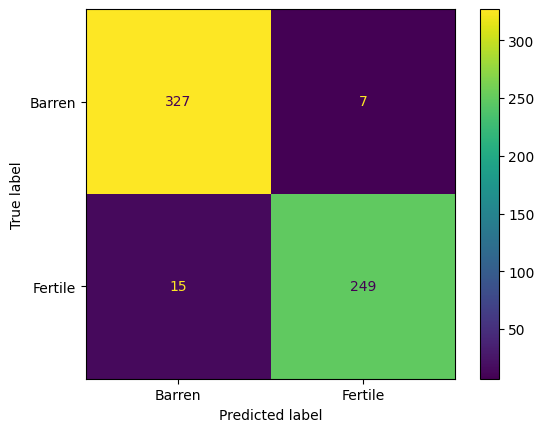

In [41]:
cm = confusion_matrix(y_test, preds_best_rf)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

In [42]:
metrics.roc_auc_score(y_test, preds_best_rf)

0.9611118671747415

### ROC-AUC Curve

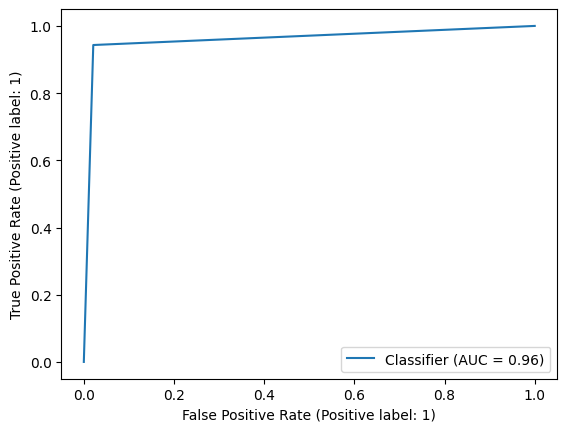

In [43]:
metrics.RocCurveDisplay.from_predictions(y_test, preds_best_rf)

### Plotting the decision boundary

In [44]:
input_features = X_test_scaled.copy()
output_feature = y_test.copy()

In [45]:
pca = PCA(n_components = 2)

X_reduced = pca.fit_transform(input_features)

In [46]:
X_reduced.shape

(598, 2)

In [47]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [48]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [51]:
plot_model = ensemble.RandomForestClassifier(**best_params)

plot_model.fit(X_reduced, output_feature)

RandomForestClassifier(criterion='entropy', max_depth=13, max_features='log2',
                       n_estimators=490)

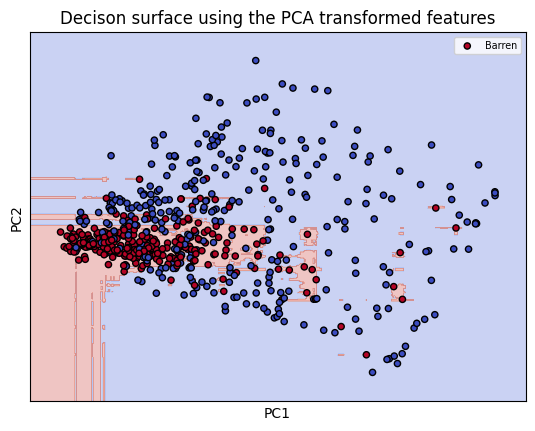

In [52]:
fig, ax = plt.subplots(facecolor='white')

# title for the plots
title = ('Decision surface of Tuned SVC ')

# Set-up grid for plotting.
X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, plot_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3) # alpha=0.8
ax.scatter(X0, X1, c=y_test, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed features')
ax.legend(labels=['Barren', 'Fertile'], fontsize="x-small")
plt.show()